In [ ]:
!pip install numpy==1.23.5 matplotlib scikit-learn
!pip install --force-reinstall pandas tensorflow
!pip show tensorflow

  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.14 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.14 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
pandas-stubs 2.1.4.231227 requires numpy>=1.26.0; python_version < "3.13", but you have numpy 1.23.5 which is i

  Using cached pandas-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
import joblib
from google.colab import files

In [ ]:
# Set random seed
seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)

# Suppresses Warning
import warnings
warnings.filterwarnings('ignore')

# Load data
data = pd.read_csv('real_data.csv', delimiter=',', header=0)
print(data.shape)
data.head(5)

(33507, 3)


,seq,pIC50,allele
0,AAAAFEAAL,0.522653,HLA-B48:01
1,AAAAFEAAL,0.527533,HLA-C14:02
2,AAADFAHAE,0.044160,HLA-B44:03
3,AAAKTPVIV,0.033761,HLA-A02:01
4,AAAKTPVIV,0.296580,HLA-A68:02


In [ ]:
 #Assuming 'seq' is the column you want to split
max_length = 10  # Set the maximum length you want to consider

# Create separate columns for each amino acid
for i in range(max_length):
    colname = 'seq' + str(i)
    data[colname] = data['seq'].str.slice(i, i + 1)  # Extract one character at a time

# Display the first rows to check the result
print(data.head(5))

         seq     pIC50      allele seq0 seq1 seq2 seq3 seq4 seq5 seq6 seq7  \
0  AAAAFEAAL  0.522653  HLA-B48:01    A    A    A    A    F    E    A    A   
1  AAAAFEAAL  0.527533  HLA-C14:02    A    A    A    A    F    E    A    A   
2  AAADFAHAE  0.044160  HLA-B44:03    A    A    A    D    F    A    H    A   
3  AAAKTPVIV  0.033761  HLA-A02:01    A    A    A    K    T    P    V    I   
4  AAAKTPVIV  0.296580  HLA-A68:02    A    A    A    K    T    P    V    I   

  seq8 seq9  
0    L       
1    L       
2    E       
3    V       
4    V       


In [ ]:
# Number of unique letters
print(len(data['seq0'].unique()))


20


In [ ]:
# Split into features and target
X_df = data.drop(['pIC50', 'seq'], axis=1)
X_df['allele'] = data['allele']
y = data['pIC50']
print(X_df.shape)
print(y.shape)
print(X_df.head(1))

(33507, 11)
(33507,)
       allele seq0 seq1 seq2 seq3 seq4 seq5 seq6 seq7 seq8 seq9
0  HLA-B48:01    A    A    A    A    F    E    A    A    L     


In [ ]:
# One-hot encode categorical features
enc = OneHotEncoder(handle_unknown='ignore')
X_enc = enc.fit_transform(X_df)
print(type(X_enc))
print(X_enc.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(33507, 313)


In [ ]:
# Convert to numpy array
X_pool = X_enc.toarray()
y_pool = y.to_numpy().reshape(-1, 1)
print(type(X_pool))
print(X_pool.shape)
y_pool = y.to_numpy()
print(y_pool.shape)

<class 'numpy.ndarray'>
(33507, 313)
(33507,)


In [ ]:
print(X_pool)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Split remaining pool of data
X_train, X_test, y_train, y_test = train_test_split(X_pool, y_pool, test_size=0.33, random_state=seed)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22449, 313)
(22449,)
(11058, 313)
(11058,)


In [ ]:
# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])


In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train_scaled.shape[1]), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0)


In [ ]:
# Save the model
model.save('lstm_model.keras')

# Save the OneHotEncoder and MinMaxScaler
joblib.dump(enc, 'onehotencoder.joblib')
joblib.dump(scaler, 'minmaxscaler.joblib')

# Download the files
#files.download('lstm_model.keras')
#files.download('onehotencoder.joblib')
#files.download('minmaxscaler.joblib')

['minmaxscaler.joblib']

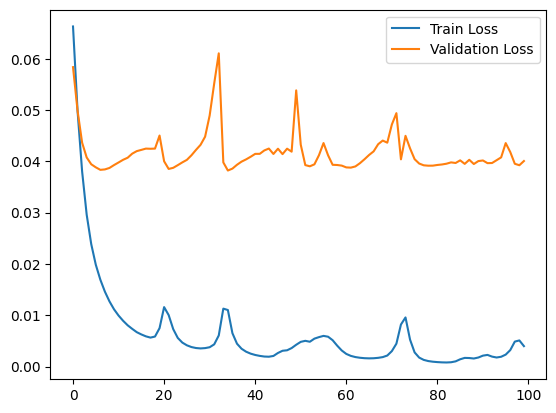

In [ ]:
# Plot training history (optional)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error on the test set: {mse}')
print(f'R-squared on the test set: {r2}')

346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Mean Squared Error on the test set: 0.04036788078758813
R-squared on the test set: 0.48898042620533777


In [ ]:
# Load the LSTM model
model = load_model('lstm_model.keras')

# Load the OneHotEncoder and MinMaxScaler
enc = joblib.load('onehotencoder.joblib')
scaler = joblib.load('minmaxscaler.joblib')

# Function to preprocess a single input
def preprocess_input(sequence, allele, enc, scaler):
    # Create separate columns for each amino acid in the sequence
    max_length = 10
    seq_data = pd.DataFrame([sequence], columns=['seq'])
    for i in range(max_length):
        colname = 'seq' + str(i)
        seq_data[colname] = seq_data['seq'].str.slice(i, i + 1)

    # Create a DataFrame for the allele
    allele = pd.DataFrame([allele], columns=['allele'])

    # Concatenate sequence and allele DataFrames
    input_data = pd.concat([allele, seq_data.drop(['seq'], axis=1)], axis=1)

    # One-hot encode categorical features
    X_enc = enc.transform(input_data).toarray()

    # Normalize features
    X_scaled = scaler.transform(X_enc)

    # Reshape data for LSTM
    X_lstm = X_scaled.reshape(1, 1, X_scaled.shape[1])

    return X_lstm

# Prompt user to enter a sequence and allele
user_sequence = input("Enter the amino acid sequence: ")
user_allele = input("Enter the HLA allele (e.g., 'HLA-B48:01'): ")

# Preprocess the user input
processed_input = preprocess_input(user_sequence, user_allele, enc, scaler)

# Make a prediction
prediction = model.predict(processed_input)

# Print the prediction
print(f'Predicted pIC50 value: {prediction[0, 0]}')


Enter the amino acid sequence: AAADFAHAE
Enter the HLA allele (e.g., 'HLA-B48:01'): HLA-C14:02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Predicted pIC50 value: 0.42613932490348816
